# NWFZ Population over time

## Sources

- Population Data (Total Population on 01 July): United Nations, Department of Economic and Social Affairs, Population Division (2022). World Population Prospects 2022, Online Edition. Retrieved from [population.un.org/wpp/Download/Standard/CSV/](https://population.un.org/wpp/Download/Standard/CSV/)


In [3]:
import pandas as pd
population_raw = pd.read_csv("./tmp/WPP2022_TotalPopulationBySex.csv")

C:\Users\max\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3460: DtypeWarning: Columns (2,3,4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<Axes: xlabel='Time'>

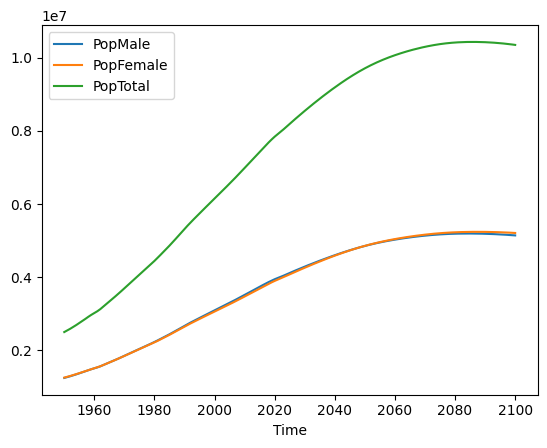

In [25]:
# ger = population_raw.loc[
#     (population_raw["ISO3_code"] == "DEU")
#     & (population_raw["Variant"] == "Medium")
# ]

ger = population_raw.loc[
    (population_raw["Location"] == "World")
    & (population_raw["Variant"] == "Medium")
]

# ger

ger.plot(kind="line", y=["PopMale", "PopFemale", "PopTotal"], x="Time")
